In [1]:
%load_ext autoreload

%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import torch

sys.path.append('..')

from torch import nn
from Utils.NeuralNetworks import SigmoidNeuralNetwork
from Utils.utils import load_data, run_multiple_nn, run_multiple_forest, run_multiple_logistics
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

# Define Paramaters

In [2]:
base_seed = 42
base_feature_size = 18
baseline_accuracy = 0.875

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


# Neural Network

In [3]:
X_train, y_train, _, _, feature_size  = load_data(base_seed, base_feature_size, discreteize=True, expand=False)

### Performing grid search

In [4]:
net = NeuralNetClassifier(
    module=SigmoidNeuralNetwork,
    max_epochs=50,
    criterion=nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=0.01,
    batch_size=2048,
    module__input_size=feature_size,
    device=device,
    train_split=None
)

params = {
    'optimizer__lr': [0.1, 0.01, 0.001],
    'max_epochs': [50],
    'batch_size': [1024],
    'module__layer_size': [64, 128],
    'module__layer_no': [1, 2],
    'optimizer__weight_decay': [1e-3, 1e-2],
}

gs = GridSearchCV(net, params, refit=False, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)
clf = gs.fit(X_train, y_train.astype(float))

Fitting 10 folds for each of 24 candidates, totalling 240 fits


In [ ]:
net = NeuralNetClassifier(
    module=SigmoidNeuralNetwork,
    max_epochs=50,
    criterion=nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=0.01,
    batch_size=2048,
    module__input_size=feature_size,
    device=device,
    train_split=None
)

params = {
    'optimizer__lr': [0.1, 0.01, 0.001],
    'max_epochs': [50],
    'batch_size': [2048],
    'module__layer_size': [64, 128],
    'module__layer_no': [1, 2],
    'optimizer__weight_decay': [1e-3, 1e-2],
}

gs = GridSearchCV(net, params, refit=False, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)
clf = gs.fit(X_train, y_train.astype(float))

Fitting 10 folds for each of 24 candidates, totalling 240 fits


In [5]:
print("Best parameters found: ", gs.best_params_)
print("Best accuracy found: ", gs.best_score_)

Best parameters found:  {'batch_size': 1024, 'max_epochs': 50, 'module__layer_no': 1, 'module__layer_size': 128, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.001}
Best accuracy found:  0.9488194444444444


### Assesing performance

In [6]:
nn_results = run_multiple_nn(gs, base_feature_size=base_feature_size, device=device, no_runs=10)

Run 1 / 10 started
Run finished with test accuracy: 0.8966666666666666
Run 2 / 10 started
Run finished with test accuracy: 0.8994444444444445
Run 3 / 10 started
Run finished with test accuracy: 0.8927777777777778
Run 4 / 10 started
Run finished with test accuracy: 0.9136111111111112
Run 5 / 10 started
Run finished with test accuracy: 0.8840277777777777
Run 6 / 10 started
Run finished with test accuracy: 0.91125
Run 7 / 10 started
Run finished with test accuracy: 0.9026388888888889
Run 8 / 10 started
Run finished with test accuracy: 0.9048611111111111
Run 9 / 10 started
Run finished with test accuracy: 0.8573611111111111
Run 10 / 10 started
Run finished with test accuracy: 0.8808333333333334


In [7]:
print(nn_results.head())

os.makedirs('results', exist_ok=True)
nn_results.to_csv(f'results/nn_results_{base_feature_size}.csv')

   Seed  epoch  train_loss  train_accuracy  test_accuracy
0     0      0    0.694018        0.496285       0.896667
1     0      1    0.692243        0.520000       0.896667
2     0      2    0.691908        0.524479       0.896667
3     0      3    0.691616        0.525625       0.896667
4     0      4    0.691387        0.525660       0.896667


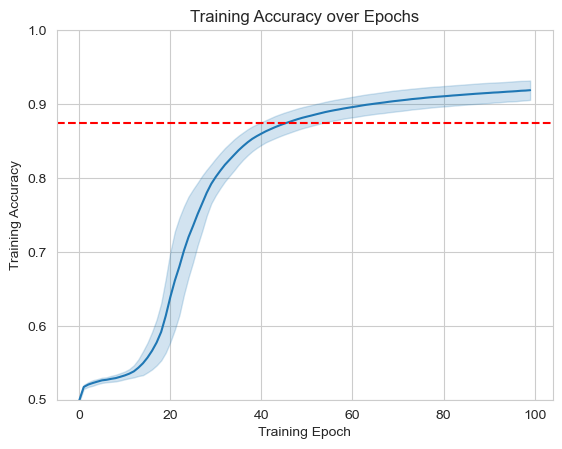

In [8]:
sns.set_style("whitegrid")
ax = sns.lineplot(data=nn_results, x='epoch', y='train_accuracy', errorbar='sd')
ax.set(xlabel='Training Epoch', ylabel='Training Accuracy', ylim=(0.5, 1.0), title='Training Accuracy over Epochs')
plt.axhline(y=baseline_accuracy, color='r', linestyle='--')
plt.show()

# Random Forrests

In [9]:
X_train, y_train, _, _, feature_size  = load_data(base_seed, base_feature_size, discreteize=True, expand=True)

### Assessing Performance

In [10]:
forrest_results = run_multiple_forest(base_feature_size, no_runs=10)

Run 1 / 10 started
Run finished with test accuracy: 0.9709722222222222
Run 2 / 10 started
Run finished with test accuracy: 0.9730555555555556
Run 3 / 10 started
Run finished with test accuracy: 0.9701388888888889
Run 4 / 10 started
Run finished with test accuracy: 0.9690277777777778
Run 5 / 10 started
Run finished with test accuracy: 0.9716666666666667
Run 6 / 10 started
Run finished with test accuracy: 0.9709722222222222
Run 7 / 10 started
Run finished with test accuracy: 0.9731944444444445
Run 8 / 10 started
Run finished with test accuracy: 0.97125
Run 9 / 10 started
Run finished with test accuracy: 0.9706944444444444
Run 10 / 10 started
Run finished with test accuracy: 0.9691666666666666


In [11]:
print(forrest_results)

os.makedirs('results', exist_ok=True)
forrest_results.to_csv(f'results/rf_results_{base_feature_size}.csv')

   run  test_accuracy
0    0       0.970972
1    1       0.973056
2    2       0.970139
3    3       0.969028
4    4       0.971667
5    5       0.970972
6    6       0.973194
7    7       0.971250
8    8       0.970694
9    9       0.969167


In [12]:
print("Random Forest Accuracy:", forrest_results['test_accuracy'].mean())
print("Baseline to beat", baseline_accuracy)

Random Forest Accuracy: 0.9710138888888888
Baseline to beat 0.875
